## Finding Maximum

First before implementing anything, we need to import the stuff we need

In [1]:
# importing QISKit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, QISKitError, QuantumJob
from qiskit import available_backends, execute, register, get_backend, compile

from qiskit.tools import visualization
from qiskit.tools.visualization import circuit_drawer

to find maximum value, first we need comparator. To make a comparator, multiple-bit-control gate is needed. We implement the n-bit-control gate here.

In [2]:
def n_control(circuit, q_array, target, ancillary_array, flip_array=None):
    # error checking
    if flip_array is not None and len(q_array) != len(flip_array):
        raise ValueError("q_array(len:{}) and flip_array(len:{}) must have the same length".format(len(q_array), len(flip_array)))
    if len(ancillary_array) < len(q_array) - 2:
        raise ValueError("ancillary array length is not enough ({}) for q_array ({})".format(len(ancillary_array), len(q_array)))
    if flip_array is None:
        flip_array = [1 for _ in range(len(q_array))]
    # todo handle wrong flip_array
    
    n = len(q_array)
    
    # put X-gate if flip
    for i in range(n):
        if flip_array[i] == -1:
            circuit.x(q_array[i])
        
    # special case for only 2 bits
    if n == 2:
        circuit.ccx(q_array[0], q_array[1], target)
    else:
        circuit.ccx(q_array[0], q_array[1], ancillary_array[0])
        for i in range(2, n-1):
            circuit.ccx(q_array[i], ancillary_array[i-2], ancillary_array[i-1])
        circuit.ccx(q_array[n-1], ancillary_array[n-3], target)
        for i in reversed(range(2, n-1)):
            circuit.ccx(q_array[i], ancillary_array[i-2], ancillary_array[i-1])
        circuit.ccx(q_array[0], q_array[1], ancillary_array[0])
    
    # clean up X-gate
    for i in range(n):
        if flip_array[i] == -1:
            circuit.x(q_array[i])

Let's see how the n_control circuit works by looking at 4-bit control gate where second and third bit should be flipped.

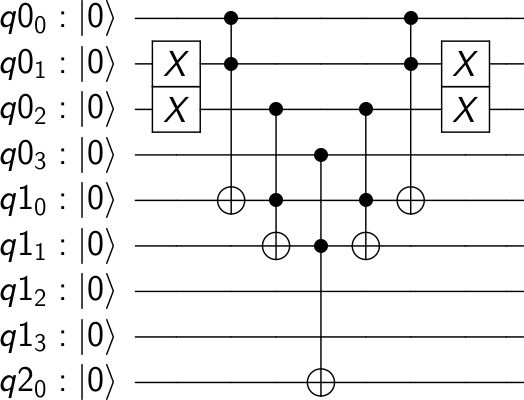

In [3]:
qc = QuantumCircuit()
q = QuantumRegister(4)
anc = QuantumRegister(4)
target = QuantumRegister(1)
qc.add(q)
qc.add(anc)
qc.add(target)

n_control(qc, [q[0], q[1], q[2], q[3]], target[0], [anc[0], anc[1], anc[2], anc[3]], [1, -1, -1, 1])

circuit_drawer(qc)

We can see that the n-control gate works fine. Now to the next step, the comparator. We'll make a 4-bit comparator thus using 8 q-bits for data (4 for A; 4 for B), 8 q-bits for ancillary, and 1 for target. The output (target) will be 1 if A is larger than B.

In [4]:
def four_bit_comparator(qc, a, b, anc, target):
    # we will store a > b for each bit in 0, 2, 4, 6 (from msb to lsb)
    # and for b > a for each bit in 1, 3, 5, 7
    
    # TODO: let's check whether anc is enough
    anc_len = len(anc)
    if anc_len < 16:
        raise ValueError("ancillary bit is not enough: anc_len is {}".format(anc_len))
    
    n = 4
    
    n_control(qc, [a[0], b[0]], anc[0], [anc[anc_len - 1]], [1, -1]) # a > b 1st bit
    n_control(qc, [a[0], b[0]], anc[1], [anc[anc_len - 1]], [-1, 1]) # a < b 1st bit
    n_control(qc, [a[1], b[1]], anc[2], [anc[anc_len - 1]], [1, -1]) # a > b 2nd bit
    n_control(qc, [a[1], b[1]], anc[3], [anc[anc_len - 1]], [-1, 1]) # a < b 2nd bit
    n_control(qc, [a[2], b[2]], anc[4], [anc[anc_len - 1]], [1, -1]) # a > b 3rd bit
    n_control(qc, [a[2], b[2]], anc[5], [anc[anc_len - 1]], [-1, 1]) # a < b 3rd bit
    n_control(qc, [a[3], b[3]], anc[6], [anc[anc_len - 1]], [1, -1]) # a > b 4th bit
    n_control(qc, [a[3], b[3]], anc[7], [anc[anc_len - 1]], [-1, 1]) # a < b 4th bit
    
    # now to the compare step
    comp_anc = [anc[8], anc[9], anc[10], anc[11], anc[12], anc[13], anc[14], anc[15]]
    qc.cx(anc[0], target)
    n_control(qc, [anc[0], anc[1], anc[2]], target, comp_anc, [-1, -1, 1])
    n_control(qc, [anc[0], anc[1], anc[2], anc[3], anc[4]], target, comp_anc, [-1, -1, -1, -1, 1])
    n_control(qc, [anc[0], anc[1], anc[2], anc[3], anc[4], anc[5], anc[6]], target, comp_anc, [-1, -1, -1, -1, -1, -1, 1])
    
    # clean up the anc               
    n_control(qc, [a[3], b[3]], anc[7], [anc[anc_len - 1]], [-1, 1]) # a < b 4th bit
    n_control(qc, [a[3], b[3]], anc[6], [anc[anc_len - 1]], [1, -1]) # a > b 4th bit
    n_control(qc, [a[2], b[2]], anc[5], [anc[anc_len - 1]], [-1, 1]) # a < b 3rd bit
    n_control(qc, [a[2], b[2]], anc[4], [anc[anc_len - 1]], [1, -1]) # a > b 3rd bit
    n_control(qc, [a[1], b[1]], anc[3], [anc[anc_len - 1]], [-1, 1]) # a < b 2nd bit
    n_control(qc, [a[1], b[1]], anc[2], [anc[anc_len - 1]], [1, -1]) # a > b 2nd bit
    n_control(qc, [a[0], b[0]], anc[1], [anc[anc_len - 1]], [-1, 1]) # a < b 1st bit
    n_control(qc, [a[0], b[0]], anc[0], [anc[anc_len - 1]], [1, -1]) # a > b 1st bit

Let's see if how the comparator circuit goes

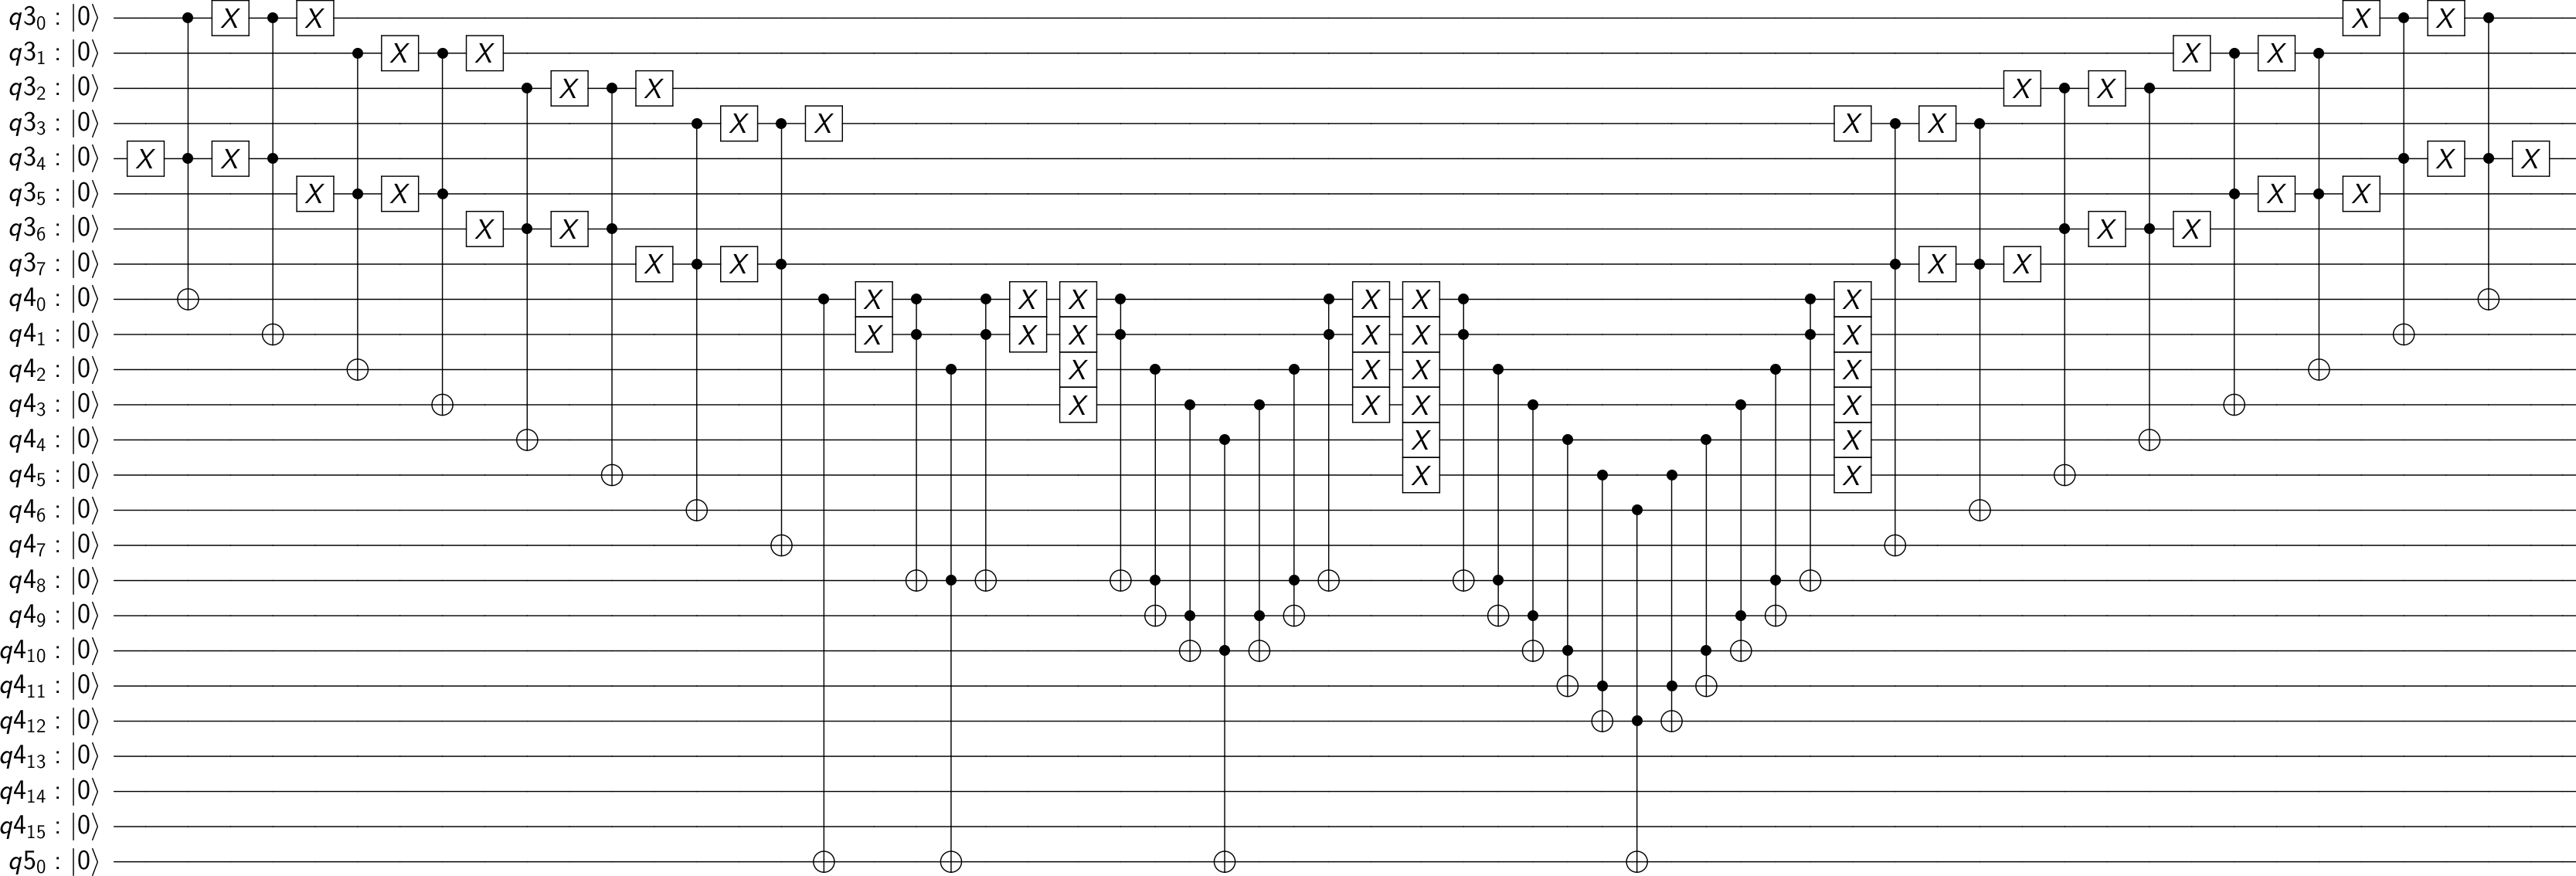

In [5]:
qc = QuantumCircuit()
q = QuantumRegister(8)
anc = QuantumRegister(16)
target = QuantumRegister(1)
qc.add(q)
qc.add(anc)
qc.add(target)

four_bit_comparator(qc, [q[0], q[1], q[2], q[3]], [q[4], q[5], q[6], q[7]], anc, target[0])

circuit_drawer(qc)

Now, we need to implement the Grover's search algorithm which we will used in the process of finding the maximum value.

since we already have the comparator as the black box Uf function the next step is to implement the inversion around the mean.

In [6]:
def inv_around_mean(circuit, qs, anc):
    n = len(qs)
    for i in range(n):
        circuit.h(qs[i])
    for i in range(n):
        circuit.x(qs[i])
    circuit.h(qs[n-1])
    n_control(circuit, [q[i] for i in range(n-1)], q[n-1], anc)
    circuit.h(qs[n-1])
    for i in range(n):
        circuit.x(qs[i])
    for i in range(n):
        circuit.h(qs[i])
    

Let's see how the inversion around the mean circuit looks

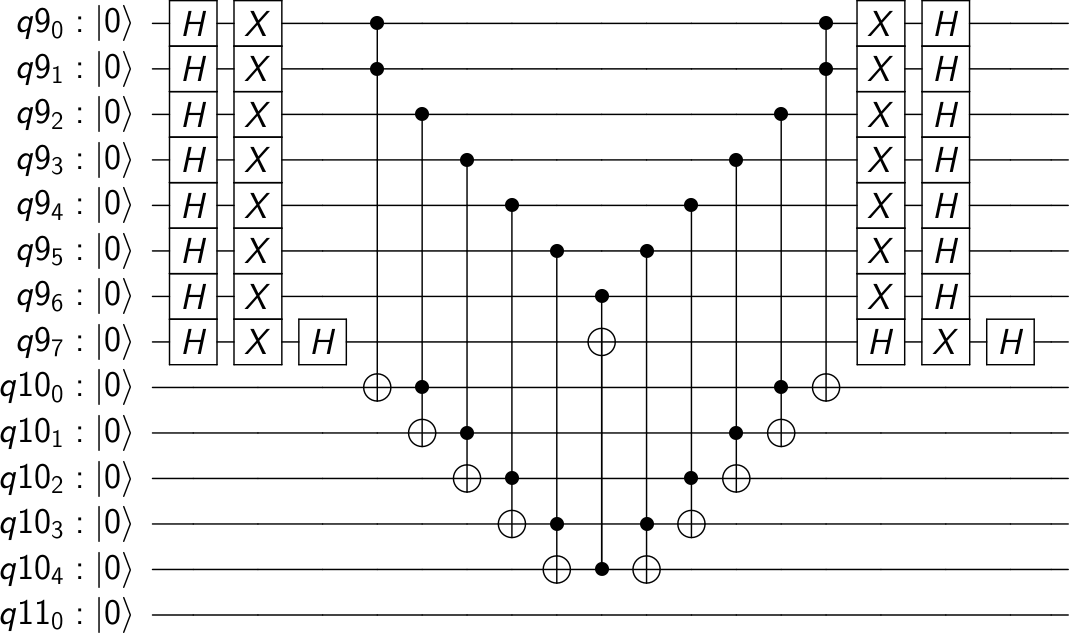

In [8]:
qc = QuantumCircuit()
q = QuantumRegister(8)
anc = QuantumRegister(5)
target = QuantumRegister(1)
qc.add(q)
qc.add(anc)
qc.add(target)

# four_bit_comparator(qc, [q[0], q[1], q[2], q[3]], [q[4], q[5], q[6], q[7]], anc, target[0])
inv_around_mean(qc, [q[i] for i in range(8)], [anc[i] for i in range(len(anc))])

circuit_drawer(qc)

Now what's left is to contruct Grover's iteration by making the black box function Uf from 4-bit comparator.